### Canada Basin freshwater content

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import warnings
import seaborn as sns
import glob
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Parameters:

In [3]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref = '/data/brogalla/run_storage/Mn-set4-202004/'
folder_sed = '/data/brogalla/run_storage/Mn-nosed-202005/'
folder_riv = '/data/brogalla/run_storage/riv-2a-202005/'
folder_con = '/data/brogalla/run_storage/riv-2b-202005/'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(164/N, 1, N)
vals_cont[:, 1] = np.linspace(116/N, 1, N)
vals_cont[:, 2] = np.linspace(84/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(113/N, 1, N)
vals_glac[:, 1] = np.linspace(169/N, 1, N)
vals_glac[:, 2] = np.linspace(144/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [4]:
# Meshmasks
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

##### Functions:

In [6]:
def calculate_diff(year):
    
    files_base  = np.sort(glob.glob(folder_ref+'ref-'   +str(year)+'/ANHA12_EXH006_5d*'))
    files_glac  = np.sort(glob.glob(folder_riv+'riv-2a-'+str(year)+'/ANHA12_EXH006_5d*'))
    files_cont  = np.sort(glob.glob(folder_con+'riv-2b-'+str(year)+'/ANHA12_EXH006_5d*'))
    files_nosed = np.sort(glob.glob(folder_sed+'nosed-' +str(year)+'/ANHA12_EXH006_5d*'))

    glacier_contribution   = np.empty((len(files_base),50,isize,jsize))
    continent_contribution = np.empty((len(files_base),50,isize,jsize))
    sediment_contribution  = np.empty((len(files_base),50,isize,jsize))
    
    for file_ind in range(0,len(files_base)):
        base_fday  = nc.Dataset(files_base[file_ind]);
        glac_fday  = nc.Dataset(files_glac[file_ind]);
        cont_fday  = nc.Dataset(files_cont[file_ind]);
        nosed_fday = nc.Dataset(files_nosed[file_ind]);

        dmn_base  = np.array(base_fday.variables['dissolmn'])[0,:,:,:]
        dmn_glac  = np.array(glac_fday.variables['dissolmn'])[0,:,:,:]
        dmn_cont  = np.array(cont_fday.variables['dissolmn'])[0,:,:,:]
        dmn_nosed = np.array(nosed_fday.variables['dissolmn'])[0,:,:,:]

        glacier_contribution[file_ind,:,:,:]   = dmn_glac - dmn_base
        continent_contribution[file_ind,:,:,:] = dmn_cont - dmn_base
        sediment_contribution[file_ind,:,:,:]  = dmn_base - dmn_nosed
    
    return glacier_contribution, continent_contribution, sediment_contribution

In [7]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31,12)
    
    file_list1E = np.sort(os.listdir('/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

##### Calculations:

Create mask for Canada Basin:

In [8]:
mask_ini_CB  = np.ones(lon.shape) # full domain size
mask_ini_CB[0:imin+10, :] = 0 # remove the boundaries
mask_ini_CB[imax-10:, :]  = 0
mask_ini_CB[:, 0:jmin]    = 0
mask_ini_CB[:, jmax-20:]  = 0

# Define Canada Basin using the 800 m contour and longitudes
# mask_CB = np.ma.masked_where((mesh_bathy < 800) & (lon > -150), mask_ini_CB)
mask_CB = np.ma.masked_where((mesh_bathy < 3200), mask_ini_CB)
mask_CB = np.ma.masked_where(lon > -80, mask_CB)

mask_CB_lons = np.ma.masked_where(mask_CB==0, lon)
mask_CB_lats = np.ma.masked_where(mask_CB==0, lat)

mask_CB_yr   = np.tile(mask_CB[imin:imax,jmin:jmax], (73,50,1,1))

Calculate the continental Mn contribution to Canada Basin over time:

In [25]:
timeseries_glac = []
timeseries_cont = []
timeseries_ice  = []

for year in range(2002, 2020):
    print(year)
    glacier, cont, sed = calculate_diff(year)
    glacier_CB    = np.ma.masked_where(mask_CB_yr==0, glacier)
    cont_CB       = np.ma.masked_where(mask_CB_yr==0, cont)
    sedice_CB     = np.ma.masked_where(mask_CB_yr==0, sed)
    
    for fday in range(0,73):
        glac_sum = np.ma.sum(glacier_CB[fday,:,:,:])
        cont_sum = np.ma.sum(cont_CB[fday,:,:,:])
        sed_sum  = np.ma.sum(sedice_CB[fday,:,:,:])

        timeseries_glac.append(glac_sum)
        timeseries_cont.append(cont_sum)
        timeseries_ice.append(sed_sum)
        
pickle.dump((timeseries_glac, timeseries_cont, timeseries_ice), \
            open('/ocean/brogalla/GEOTRACES/pickles/CB_timeseries.pickle','wb'))

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [9]:
dates = np.array([file_dates(year) for year in range(2002,2020)]).flatten()

In [10]:
ts_glac, ts_cont, ts_ice = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/CB_timeseries.pickle', 'rb'))
ts_glac = np.array(ts_glac)
ts_cont = np.array(ts_cont)
ts_ice  = np.array(ts_ice)

## Figures

Add to time series plot:
- pacific water freshwater content
- freshwater content of model --- Hu et al (2019) see a general increase in Beaufort Gyre freshwater content from 2002-2017. Identify that "the changes in FWC are not directlycaused by PW rather than linked to the variations of atmospheric circulation and sea ice melting." 

"Budget analysis suggests that this difference in Beaufort Gyre freshwater storage is mainly caused by lateral advection. The lateral freshwater flux is decomposed into two components due to theslow-varying circulation and mesoscale eddies. "

In [11]:
FWC_dates  =  np.array([dt.datetime(year,1,1) for year in range(2002,2020)])

FWC_ANHA12 = np.array([15.7, 15, 15.5, 16.5, 16.7, 16.3, 18, 17.8, 17.9, 17.9, 18.5, 18, 18.2, \
                       18.4, 18.8, 19.2, np.nan, np.nan]) # from Hu et al. (2019)
FWC_observed = np.array([np.nan, 16.5, 16.8, 17.8, 18.3, 19.4, 21.4, 21.4, 21.4, 21.3, 21.5, \
                         20.2, 21, 21.8, 22.9, np.nan, np.nan, np.nan]) # in Hu et al. (2019)

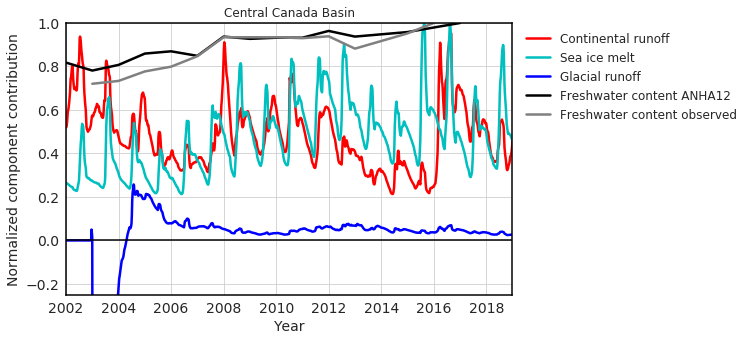

In [16]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, np.array(ts_cont)/np.amax(ts_cont), \
                 linewidth=2.5, color='r', label=r'Continental runoff')
    sns.lineplot(dates, np.array(ts_ice)/np.amax(ts_ice), \
                 linewidth=2.5, color='c', label=r'Sea ice melt', ax=ax)
    sns.lineplot(dates, np.array(ts_glac)/np.amax(np.abs(ts_glac)), \
                 linewidth=2.5, color='b', label=r'Glacial runoff', ax=ax)
    
    sns.lineplot(FWC_dates, FWC_ANHA12/np.nanmax(FWC_ANHA12), \
                 linewidth=2.5, color='k', label=r'Freshwater content ANHA12', ax=ax)
    sns.lineplot(FWC_dates, FWC_observed/np.nanmax(FWC_observed), \
                 linewidth=2.5, color='gray', label=r'Freshwater content observed', ax=ax)
    
    sns.lineplot([dates[0], dates[-1]], [0, 0], c='k')
    
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Normalized component contribution',fontsize=14)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set(ylim=(-0.25,1))
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');  
    
    ax.set_title('Central Canada Basin')

#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    leg  = ax.legend(loc=(1.02, 0.62), frameon=True, framealpha=0.7, fontsize=12)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/D2-Mn-flux-'+ \
#             str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

In [12]:
ccont = '#ce9169'
cice  = '#a1b8c4'
cglac = '#36ab92'

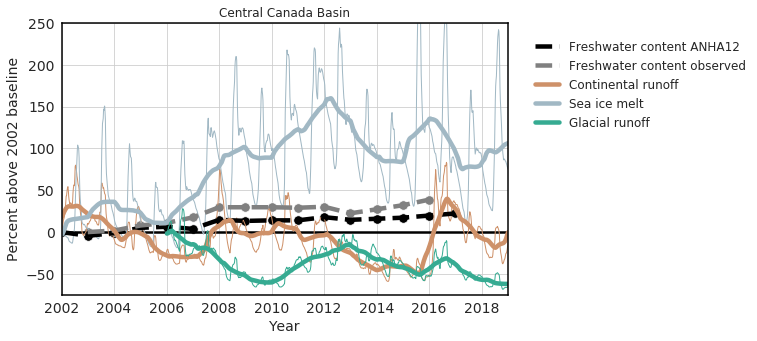

In [13]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

cont = np.array(ts_cont - ts_cont[0])*100/ts_cont[0]
ice  = np.array(ts_ice - ts_ice[0])*100/ts_ice[0]
skip_yrs = 4*73
glac = np.array(ts_glac[skip_yrs:] - ts_glac[skip_yrs])*100/np.abs(ts_glac[skip_yrs])

with st:
    
    ax = sns.lineplot([dates[0], dates[-1]], [0, 0], c='k', linewidth=2.5)
    
    # Continental Runoff and sea ice melt
    sns.lineplot(dates, cont, linewidth=1, color=ccont, ax=ax)
    sns.lineplot(dates, ice, linewidth=1, color=cice, ax=ax)
  
    # Freshwater content:
    sns.scatterplot(FWC_dates, (FWC_ANHA12-FWC_ANHA12[0])*100/FWC_ANHA12[0], s=90, \
                   color='k', ax=ax)
    sns.scatterplot(FWC_dates, (FWC_observed-FWC_observed[1])*100/FWC_observed[1], s=90, \
                    color='gray', ax=ax)
    sns.lineplot(FWC_dates, (FWC_ANHA12-FWC_ANHA12[0])*100/FWC_ANHA12[0], \
                 linewidth=4.5, color='k', label=r'Freshwater content ANHA12', ax=ax)
    sns.lineplot(FWC_dates, (FWC_observed-FWC_observed[1])*100/FWC_observed[1], \
                 linewidth=4.5, color='gray', label=r'Freshwater content observed', ax=ax)  
    ax.lines[3].set_linestyle('--')
    ax.lines[4].set_linestyle('--')

    # Moving average of continental runof and sea ice melt
    N = 73
    cont_ave = np.convolve(cont, np.ones((N,))/N, mode='same')
    ice_ave  = np.convolve(ice , np.ones((N,))/N, mode='same')
    sns.lineplot(dates[len(cont)-len(cont_ave):], cont_ave, color=ccont, linewidth=4.5, label=r'Continental runoff')
    sns.lineplot(dates[len(ice) -len(ice_ave):], ice_ave, color=cice, linewidth=4.5, label=r'Sea ice melt')
    
    # Glacial runoff:
    sns.lineplot(dates[skip_yrs:], glac, linewidth=1, color=cglac, ax=ax)
    glac_ave  = np.convolve(glac, np.ones((N,))/N, mode='same') # moving average
    sns.lineplot(dates[skip_yrs:], glac_ave, color=cglac, linewidth=4.5, label=r'Glacial runoff')
    
    # Other figure settings
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percent above 2002 baseline',fontsize=14)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set(ylim=(-75,250))
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');  
    
    ax.set_title('Central Canada Basin')
    leg  = ax.legend(loc=(1.05, 0.59), frameon=True, framealpha=0.7, fontsize=12)
    leg.get_frame().set_linewidth(0.0)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R5-CB-runoff-'+ \
            str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

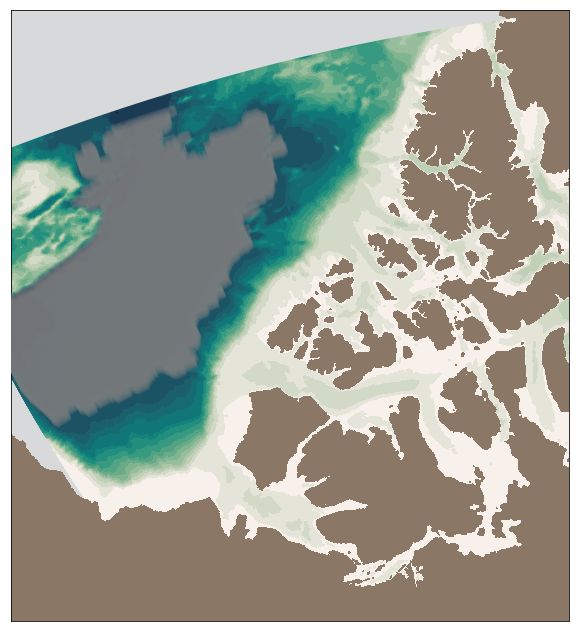

In [14]:
fig, ax1 = plt.subplots(figsize=(10,12))

proj2 = Basemap(projection='stere',lat_0 = 77, lon_0 = -120, resolution='i', width=2.1e6, height=2.3e6, ax=ax1)

x_land, y_land = proj2(lon, lat)

proj2.contourf(x_land, y_land, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=4000, zorder=1)
proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
               cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

# Draw domain boundaries:
proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , \
           '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , \
           '-', color='#d8d9da', linewidth=10, zorder=1)

# Canada Basin region definition:
x_CB, y_CB = proj2(mask_CB_lons, mask_CB_lats)
proj2.plot(x_CB, y_CB, '-', color='#818282', linewidth=10, zorder=4, alpha=0.2);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R5-domain-definition.png', bbox_inches='tight', dpi=300)